In [1]:
from __future__ import print_function

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as pyo
import seaborn as sns
from ipywidgets import fixed, interact, interact_manual, interactive
from natsort import index_natsorted
from scipy.stats import norm

%load_ext line_profiler
%matplotlib inline
pyo.init_notebook_mode(connected=True)

# Function definitions

In [2]:
drugyear_usage = {
    "fluoroquinolone antibiotic": 1962,
    "penam": 1943,
    "cephalosporin": 1964,
    "tetracycline antibiotic": 1948,
    "phenicol antibiotic": 1949,
    "macrolide antibiotic": 1952,
    "rifamycin antibiotic": 1963,
    "aminoglycoside antibiotic": 1946,
    "peptide antibiotic": 1941,  # not sure about this one
    "glycylcycline": 1948,  # using year tetracyclines were introduced clinically
    "triclosan": 1968,  # using wiki page
    "cephamycin": 1964,  # using cephalosporin year
    "carbapenem": 1985,
    "aminocoumarin antibiotic": 1965,  # best guess from wiki article
    "penem": 1985,  # using year carbapenems were introduced
    "monobactam": 1986,
    "disinfecting agents and intercalating dyes": 1930,  # no clue
                            "acridine dye": 1970,  # no clue?
    "diaminopyrimidine antibiotic": 1962,
    "elfamycin antibiotic": 1978,  # no clue
    "fosfomycin": 1971,
    "nucleoside antibiotic": 2014,  # no clue, but looks newish
    "lincosamide antibiotic": 1963,
    "nitroimidazole antibiotic": 1960,
    "Null": 1920,
    "benzalkonium chloride": 1950,  # no clude
    "rhodamine": 1950,  # no clude
    "sulfonamide antibiotic": 1936,
    "nitrofuran antibiotic": 1953,
    "streptogramin antibiotic": 1965,
    "oxazolidinone antibiotic": 2000,
    "glycopeptide antibiotic": 1958,
    "fusidic acid": 1962,
    "pleuromutilin antibiotic": 2007,
    "bicyclomycin": 1972,  # from wiki
    "antibacterial free fatty acids": 2000,  # noclude
    "para-aminosalicylic acid": 1943,
    "isoniazid": 1952,
    "polyamine antibiotic": 2005,  # no idea
}

In [3]:
def measure_obs_distance(
    dataframe, value, anthro_year, column, sums=False, verbose=False
):
    num_yearcultured_allstrains_dict = (
        dataframe.drop_duplicates(subset=["Accession_Number"])["Year_Cultured"]
        .value_counts()
        .to_dict()
    )
    num_yearcultured_valposstrains_dict = (
        dataframe.loc[dataframe[column].str.contains(value, na=False, regex=True)]
        .drop_duplicates(subset=["Accession_Number"])["Year_Cultured"]
        .value_counts()
        .to_dict()
    )
    fractional_dictionary = {}
    for years in num_yearcultured_allstrains_dict:
        if num_yearcultured_allstrains_dict[years] == 0:
            continue
        if years in num_yearcultured_valposstrains_dict:
            val = [
                num_yearcultured_valposstrains_dict[years],
                num_yearcultured_allstrains_dict[years],
            ]
        else:
            val = [0, num_yearcultured_allstrains_dict[years]]
        fractional_dictionary[years] = val

    yeardf = (
        pd.DataFrame.from_dict(
            fractional_dictionary, orient="index", columns=["num_pos", "all"]
        )
        .reset_index()
        .rename(columns={"index": "year"})
        .sort_values(by="year")
        .reset_index(drop=True)
    )
    yeardf["frac"] = yeardf["num_pos"] / yeardf["all"]
    if verbose:
        print(yeardf)
    anthro = {True: "Pre-Human", False: "Post-Human"}
    yeardf["Anthropogenicity"] = "Pre-Human"
    yeardf.loc[yeardf["year"] > anthro_year, "Anthropogenicity"] = "Post-Human"

    preanthro_mean = yeardf.loc[yeardf["Anthropogenicity"] == "Pre-Human"][
        "frac"
    ].mean()
    postanthro_mean = yeardf.loc[yeardf["Anthropogenicity"] == "Post-Human"][
        "frac"
    ].mean()
    metric = postanthro_mean - preanthro_mean
    return yeardf, preanthro_mean, postanthro_mean


# shuffle year_cultured information while retaining existing structure.
#  i.e. all 1940 strains get remapped to 2019, all 2019 strains get remapped to 1982, etc.
def shuffleyears_structured(
    dataframe, value, anthro_year, column, verbose=False, simulations=500
):
    null_distances = []
    sortedyears = dataframe["Year_Cultured"].unique()
    for sim in range(simulations):
        copy_df = dataframe.copy()
        shuffledyears = dataframe["Year_Cultured"].sample(frac=1).unique()
        remapping = dict(zip(sortedyears, shuffledyears))
        copy_df["Year_Cultured"] = dataframe["Year_Cultured"].map(remapping)
        yeardf, pre, post = measure_obs_distance(
            copy_df, value, anthro_year, column, verbose
        )
        null_distances.append(post - pre)
    return null_distances


# shuffle year_cultured information while NOT retaining existing structure.
#  i.e. some 1940 strains can get remapped to 2019, some can get remapped to 1930, etc.
def shuffleyears_unstructured(
    dataframe, value, anthro_year, column, verbose=False, simulations=500
):
    null_distances = []
    sortedyears = dataframe["Year_Cultured"].unique()
    uq_strains = (
        dataframe.groupby(["Accession_Number", "Year_Cultured"], sort=False)
        .size()
        .reset_index()
    )
    uq_strains.set_index("Accession_Number", inplace=True)
    uq_strains.drop(columns=[0, "Year_Cultured"], inplace=True)
    for sim in range(simulations):
        uq_strains["RandomChoice"] = np.random.choice(sortedyears, uq_strains.shape[0])
        copy_df = dataframe.copy()
        remapping = uq_strains.to_dict()["RandomChoice"]
        copy_df["Year_Cultured"] = dataframe["Accession_Number"].map(remapping)
        yeardf, pre, post = measure_obs_distance(
            copy_df, value, anthro_year, column, verbose
        )
        null_distances.append(post - pre)
    return null_distances

In [4]:
import scipy.stats as stats
from scipy.stats import binom


def calculate_frequency_bounds(row, confidence=0.95):
    successes = row["num_pos"]
    attempts = row["all"]
    freq = row["num_pos"] / row["all"]
    alpha = successes + 1
    beta = attempts - successes + 1
    lower_b, upper_b = stats.beta.interval(confidence, alpha, beta)
    return (lower_b, upper_b)


def plot_abresist_frac_error(
    df,
    ex,
    year,
    verbose=True,
    sims=100,
    figname="doodoo",
    savefig=False,
    smooth=5,
    col="Drug Class",
    value="phenotype",
    yaxis="Fraction of isolates with",
):

    sns.set_theme(font="Arial", style="white", font_scale=0.7)

    frac_df, pre, post = measure_obs_distance(df, ex, year, col, verbose)
    dist = post - pre

    print(frac_df)

    # histogram of fraction of strains w/ RGI hits for drug class
    plt.figure(figsize=(14, 8))
    chart = sns.barplot(
        data=frac_df, x="year", y="frac", color="salmon", saturation=0.5
    )
    chart.bar_label(chart.containers[0])

    plt.axvline(pd.Index(frac_df["year"]).get_loc(year, method="nearest"))
    plt.ylabel("Fraction of bugs with phenotype")
    plt.xlabel("Year")
    plt.xticks(rotation=45)

    plt.show()

    d = {"Year": [], "num_pos": [], "all": [], "Anthropogenicity": []}
    for years in range(frac_df["year"].min(), frac_df["year"].max()):
        upb = smooth + years
        downb = years - smooth
        g = frac_df.loc[(frac_df["year"] <= upb) & (downb <= frac_df["year"])]
        if years not in frac_df["year"].values:
            continue
        d["Year"].append(years)
        if years >= year:
            d["Anthropogenicity"].append("Post-Human")
        else:
            d["Anthropogenicity"].append("Pre-Human")
        d["num_pos"].append(g["num_pos"].sum())
        d["all"].append(g["all"].sum())
    xdf = pd.DataFrame(data=d)
    print(xdf)
    xdf["frac"] = xdf["num_pos"] / xdf["all"]
    xdf[["lower-error", "upper-error"]] = xdf.apply(
        calculate_frequency_bounds, axis=1, result_type="expand"
    )

    # make subplots for the figure
    fig1, ax1 = plt.subplots(figsize=(14, 8))

    ax1.set(xlabel="Year Cultured")

    lp = sns.lineplot(
        data=xdf,
        x="Year",
        y="frac",
        markers=True,
        hue="Anthropogenicity",
        palette=[sns.color_palette("deep")[0], sns.color_palette("deep")[1]],
        ax=ax1,
    )
    lp.set(ylim=(0, 1))

    # Get the current legend
    legend = ax1.legend()

    # Change the legend title
    legend.set_title("")

    # Change legend labels
    new_labels = ["Pre-clinical", "Post-clinical"]
    for t, l in zip(legend.texts[0:], new_labels):
        t.set_text(l)

    dp = sns.scatterplot(
        data=xdf,
        x="Year",
        y="frac",
        hue="Anthropogenicity",
        palette=[sns.color_palette("deep")[0], sns.color_palette("deep")[1]],
        legend=False,
        ax=ax1,
        edgecolor="none",
    )
    plt.fill_between(
        xdf.loc[xdf["Year"] < year]["Year"],
        xdf.loc[xdf["Year"] < year]["lower-error"],
        xdf.loc[xdf["Year"] < year]["upper-error"],
        alpha=0.3,
        edgecolor=sns.color_palette("deep")[0],
        facecolor=sns.color_palette("deep")[0],
    )
    plt.fill_between(
        xdf.loc[xdf["Year"] >= year]["Year"],
        xdf.loc[xdf["Year"] >= year]["lower-error"],
        xdf.loc[xdf["Year"] >= year]["upper-error"],
        alpha=0.3,
        edgecolor=sns.color_palette("deep")[1],
        facecolor=sns.color_palette("deep")[1],
    )
    sns.despine()
    plt.axvline(year, color="red")
    ax1.set(ylabel="{} with {}".format(yaxis, value))
    plt.axvline(year, color="red")  # , label='{} introduced'.format(year))
    trans = ax1.get_xaxis_transform()
    plt.text(
        year - 4,
        0.3,
        "Introduced clinically in {}".format(year),
        rotation=90,
        transform=trans,
        fontsize="small",
    )
    preab_df = xdf.loc[xdf["Anthropogenicity"] == "Pre-Human"]
    lp.hlines(
        y=preab_df["frac"].mean(),
        xmin=preab_df["Year"].min(),
        xmax=preab_df["Year"].max(),
        color=sns.color_palette("deep")[0],
    )

    postab_df = xdf.loc[xdf["Anthropogenicity"] == "Post-Human"]
    lp.hlines(
        y=postab_df["frac"].mean(),
        xmin=postab_df["Year"].min(),
        xmax=postab_df["Year"].max(),
        color=sns.color_palette("deep")[1],
    )
    if savefig:
        plt.gcf().set_size_inches(5.0, 3)
        plt.savefig(
            "{}-fractionofresist.svg".format(figname),
            bbox_inches="tight",
            dpi=300,
        )

    fig2, ax2 = plt.subplots(figsize=(14, 8))
    ax2.set(ylabel="Count of isolates analyzed", xlabel="Year Cultured")
    # create another copy of the dataframe
    drop_dups = df.drop_duplicates(subset=["Accession_Number"]).copy()
    drop_dups["Anthropogenicity"] = "Post-Human"

    drop_dups.loc[drop_dups["Year_Cultured"] < year, ["Anthropogenicity"]] = "Pre-Human"
    histogram = sns.histplot(
        data=drop_dups,
        x="Year_Cultured",
        hue="Anthropogenicity",
        palette=[sns.color_palette("deep")[0], sns.color_palette("deep")[1]],
        ax=ax2,
        cumulative=True,
        fill=False,
        element="step",
    )

    # Manually create a legend
    new_labels = ["Pre-clinical", "Post-clinical"]
    handles = [plt.Line2D([], [], color=color) for color in ["tab:blue", "tab:orange"]]
    ax2.legend(handles, new_labels, title="")

    plt.tight_layout()
    sns.despine()
    if savefig:
        plt.gcf().set_size_inches(5.0, 3)
        plt.savefig(
            "{}-histogram.svg".format(figname),
            bbox_inches="tight",
            dpi=300,
        )
    plt.show()

    if sims == 0:
        return

    preab_mean = frac_df.loc[frac_df["Anthropogenicity"] == "Pre-Human"]["frac"].mean()
    postab_mean = frac_df.loc[frac_df["Anthropogenicity"] == "Post-Human"][
        "frac"
    ].mean()

    nulldist = shuffleyears_structured(df, ex, year, col, verbose, simulations=sims)
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.histplot(
        nulldist, stat="density", color=sns.color_palette("deep")[0], linewidth=0
    )
    xmin, xmax = plt.xlim()
    mu_struct, std_struct = norm.fit(nulldist)
    x = np.linspace(xmin, xmax, sims)
    y_pdf = norm.pdf(x, mu_struct, std_struct)
    plt.plot(x, y_pdf, "k", linewidth=2)
    plt.axvline(dist, color="red")
    trans = ax.get_xaxis_transform()
    # x = 10
    plt.text(
        dist * 0.85,
        0.5,
        "Observed $\Delta$ = {:.3f}".format(dist),
        rotation=90,
        transform=trans,
        fontsize="x-small",
    )
    plt.title("Structured Shuffling")
    plt.xlabel("Null $\Delta$ distribution in {} simulations".format(sims))
    sns.despine()
    pval = norm.cdf(dist, mu_struct, std_struct)
    if pval > 0.5:
        pval = 1 - pval
    ax = plt.gca()
    ax.text(
        0.95,
        0.95,
        "p-value = {:.3f}".format(pval),
        transform=ax.transAxes,
        verticalalignment="top",
        horizontalalignment="right",
        bbox=dict(facecolor="white", edgecolor="none", boxstyle="round"),
    )

    if savefig:
        plt.gcf().set_size_inches(2, 3)
        plt.savefig(
            "{}-structuredshuffling.svg".format(figname), bbox_inches="tight", dpi=300
        )
    plt.show()

    nulldist = shuffleyears_unstructured(df, ex, year, col, verbose, simulations=sims)
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.histplot(
        nulldist, stat="density", color=sns.color_palette("deep")[0], edgecolor="none"
    )
    xmin, xmax = plt.xlim()
    mu_unstruct, std_unstruct = norm.fit(nulldist)
    x = np.linspace(xmin, xmax, sims)
    y_pdf = norm.pdf(x, mu_unstruct, std_unstruct)
    plt.plot(x, y_pdf, "k", linewidth=2)
    plt.axvline(dist, color="red")
    trans = ax.get_xaxis_transform()
    plt.text(
        dist * 0.85,
        0.5,
        "Observed $\Delta$ = {:.3f}".format(dist),
        rotation=90,
        transform=trans,
        fontsize="x-small",
    )
    plt.title("Unstructured Shuffling")
    plt.xlabel("Null $\Delta$ distribution in {} simulations".format(sims))
    sns.despine()
    pval = norm.cdf(dist, mu_struct, std_struct)
    if pval > 0.5:
        pval = 1 - pval
    ax = plt.gca()
    ax.text(
        0.95,
        0.95,
        "p-value = {:.3f}".format(pval),
        transform=ax.transAxes,
        verticalalignment="top",
        horizontalalignment="right",
        bbox=dict(facecolor="white", edgecolor="none", boxstyle="round"),
    )
    if savefig:
        plt.gcf().set_size_inches(2, 3)
        plt.savefig(
            "{}-unstructuredshuffling.svg".format(figname), bbox_inches="tight", dpi=300
        )
    plt.show()
    pval = norm.cdf(dist, mu_unstruct, std_unstruct)
    if pval > 0.5:
        pval = 1 - pval
    print("P-value (unstructured) = {:.4f}".format(pval))

# RGI - Beta-lactamase prevalence

In [7]:
df = pd.read_csv("../../data/3_analysis-resistance/all_rgiout_2022-12-01", sep="\t")
failed_qc = pd.read_csv("/n/data1/hms/dbmi/baym/arya/projects/project_microtrawler/data/6_checkm2/failed_filter.tsv", sep="\t")
df = df[~df['Accession_Number'].isin(failed_qc['NCTC_Isolate'])]
df = df.sort_values(
    by=["Accession_Number"],
    ascending=True,
    key=lambda x: np.argsort(index_natsorted(df["Accession_Number"])),
    ignore_index=True,
)
df[["Species", "Subspecies"]] = df["Strain"].str.split("subsp.", 1, expand=True)
df = df.replace(np.nan, "Null", regex=True)

rgiintegron = pd.read_csv(
    "../../data/3_analysis-resistance/rgi_subset_integronoverlap",
    sep="\t",
    names=df.columns.values,
)
rgiintegron["Species"] = rgiintegron["Strain"].str.split("subsp.", 1, expand=True)
rgiintegron["Subspecies"] = "Null"
contigdf = pd.concat(
    [
        df["Accession_Number"],
        df["Contig"].str.split("_", expand=True)[0].str.split("|").str[-1],
    ],
    axis=1,
).copy()

ecoli_mlplasmid_out = pd.read_csv(
    "../../data/3_analysis-plasmid/merged-Escherichia_coli-mlplasmidout", sep="\t"
)
ecoli_mlplasmid_out["Contig"] = ecoli_mlplasmid_out["Contig_name"].str.split(
    " ", expand=True
)[0]
ecoliplasmids_df = contigdf.loc[
    contigdf["Accession_Number"].isin(ecoli_mlplasmid_out["AccNum"])
]
ecoliplasmids_df = ecoliplasmids_df.loc[
    ecoliplasmids_df[0].isin(ecoli_mlplasmid_out["Contig"])
]
ecoliplasmids_df = df.loc[ecoliplasmids_df.index].copy()
df

,Accession_Number,Strain,Assembly_No,Year_Cultured,ORF_ID,Contig,Start,Stop,Orientation,Cut_Off,...,Predicted_DNA,Predicted_Protein,CARD_Protein_Sequence,Percentage Length of Reference Sequence,ID,Model_ID,Nudged,Note,Species,Subspecies
0,NCTC1,Shigella flexneri,1,1914,ENA|LM651928|LM651928.1_231 # 254564 # 255658 ...,ENA|LM651928|LM651928.1_231,254564.0,255658.0,+,Strict,...,ATGGAAAAACTGCGGGTAGGAATCGTTTTTGGTGGTAAATCAGCGG...,MEKLRVGIVFGGKSAEHEVSLQSAKNIVDAIDKSRFDVVLLGIDKQ...,MQNKKIAVIFGGNSTEYEVSLQSASAVFENINTNKFDIIPIGITRS...,104.3,gnl|BL_ORD_ID|1071|hsp_num:0,1157.0,Null,Null,Shigella flexneri,Null
1,NCTC1,Shigella flexneri,1,1914,ENA|LM651928|LM651928.1_406 # 416835 # 419984 ...,ENA|LM651928|LM651928.1_406,416835.0,419984.0,-,Strict,...,ATGCCTAATTTCTTTATCGATCGCCCGATTTTTGCGTGGGTGATCG...,MPNFFIDRPIFAWVIAIIIMLAGGLAILKLPVAQYPTIAPPAVTIS...,MPNFFIDRPIFAWVIAIIIMLAGGLAILKLPVAQYPTIAPPAVTIS...,100.0,gnl|BL_ORD_ID|1013|hsp_num:0,1104.0,Null,Null,Shigella flexneri,Null
2,NCTC1,Shigella flexneri,1,1914,ENA|LM651928|LM651928.1_407 # 420007 # 421200 ...,ENA|LM651928|LM651928.1_407,420007.0,421200.0,-,Strict,...,ATGAACAAAAACAGAGGGTTTACGCCTCTGGCGGTCGTTCTGATGC...,MNKNRGFTPLAVVLMLSGSLALTGCDDKQAQQGGQQMPAVGVVTVK...,MNKNRGFTPLAVVLMLSGSLALTGCDDKQAQQGGQQMPAVGVVTVK...,100.0,gnl|BL_ORD_ID|2328|hsp_num:0,2661.0,Null,Null,Shigella flexneri,Null
3,NCTC1,Shigella flexneri,1,1914,ENA|LM651928|LM651928.1_913 # 909925 # 911673 ...,ENA|LM651928|LM651928.1_913,909925.0,911673.0,+,Strict,...,ATGCATAACGACAAAGATCTCTCTACGTGGCAGACATTCCGCCGAC...,MHNDKDLSTWQTFRRLWPTIAPFKAGLIVAGVALILNAASDTFMLS...,MHNDKDLSTWQTFRRLWPTIAPFKAGLIVAGVALILNAASDTFMLS...,100.0,gnl|BL_ORD_ID|2192|hsp_num:0,2423.0,Null,Null,Shigella flexneri,Null
4,NCTC1,Shigella flexneri,1,1914,ENA|LM651928|LM651928.1_1084 # 1070322 # 10715...,ENA|LM651928|LM651928.1_1084,1070322.0,1071530.0,-,Strict,...,ATGTCCCGCGTATCGCAGGCGAGGAACCTGGGTAAATATTTCCTGC...,MSRVSQARNLGKYFLLIDNMLVVLGFFVVFPLISIRFVDQMGWAAV...,MSRVSQARNLGKYFLLIDNMLVVLGFFVVFPLISIRFVDQMGWAAV...,100.0,gnl|BL_ORD_ID|342|hsp_num:0,375.0,Null,Null,Shigella flexneri,Null
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29897,NCTC14382,Yersinia canariae,1,2018,ENA|CP043727|CP043727.1_3533 # 3911579 # 39121...,ENA|CP043727|CP043727.1_3533,3911579.0,3912193.0,+,Strict,...,ATGAAAGCAATAATTATTGATGACCATCCTCTTGCGATCGCCGCTA...,MKAIIIDDHPLAIAAIRNLLTKNDIEILAELVEGGSAVQRIETLKP...,MNAIIIDDHPLAIAAIRNLLIKNDIEILAELTEGGSAVQRVETLKP...,100.0,gnl|BL_ORD_ID|938|hsp_num:0,1015.0,Null,Null,Yersinia canariae,Null
29898,NCTC14382,Yersinia canariae,1,2018,ENA|CP043727|CP043727.1_3965 # 4393476 # 43941...,ENA|CP043727|CP043727.1_3965,4393476.0,4394108.0,+,Strict,...,ATGGTTCTCGGCAAGCCACAAACAGACCCGACTCTCGAATGGTTCC...,MVLGKPQTDPTLEWFLSHCHIHKYPSKSTLIHQGEKAETLYYIVKG...,MVLGKPQTDPTLEWFLSHCHIHKYPSKSKLIHQGEKAETLYYIVKG...,100.0,gnl|BL_ORD_ID|803|hsp_num:0,869.0,Null,Null,Yersinia canariae,Null
29899,NCTC14382,Yersinia canariae,1,2018,ENA|CP043727|CP043727.1_734 # 828203 # 829966 ...,ENA|CP043727|CP043727.1_734,828203.0,829966.0,+,Strict,...,ATGAAAGCAGCGCGCCCCGGGAAGTTAAAGCGCCAGGAAGAACAAG...,MKAARPGKLKRQEEQASFISWRFALLCGCILLALVGLMLRTAYLQV...,MVKFNSSRKSGKSKKTIRKLTAPETVKQNKPQKVFEKCFMRGRYML...,96.23,gnl|BL_ORD_ID|2503|hsp_num:0,2886.0,Null,Null,Yersinia canariae,Null
29900,NCTC14382,Yersinia canariae,1,2018,ENA|CP043727|CP043727.1_3889 # 4333449 # 43346...,ENA|CP043727|CP043727.1_3889,4333449.0,4334633.0,-,Strict,...,ATGTCTAAAGAAAAGTTTGAACGTACAAAACCGCACGTTAATGTGG...,MSKEKFERTKPHVNVGTIGHVDHGKTTLTAAITTVLAKTYGGSARA...,MLSPEGESTIVRNIAVSKEKFERTKPHVNVGTIGHVDHGKTTLTAA...,96.33,gnl|BL_ORD_ID|1972|hsp_num:0,2158.0,Null,Null,Yersinia canariae,Null


## All bugs

     year  num_pos  all      frac Anthropogenicity
0    1886        1    1  1.000000        Pre-Human
1    1901        0    1  0.000000        Pre-Human
2    1904        0    1  0.000000        Pre-Human
3    1905        0    1  0.000000        Pre-Human
4    1906        2    2  1.000000        Pre-Human
..    ...      ...  ...       ...              ...
103  2013        4    7  0.571429       Post-Human
104  2014        1    4  0.250000       Post-Human
105  2015        3   21  0.142857       Post-Human
106  2016        1    2  0.500000       Post-Human
107  2018        0    1  0.000000       Post-Human

[108 rows x 5 columns]


/tmp/ipykernel_18775/2187956965.py:43: FutureWarning:

Passing method to Int64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.



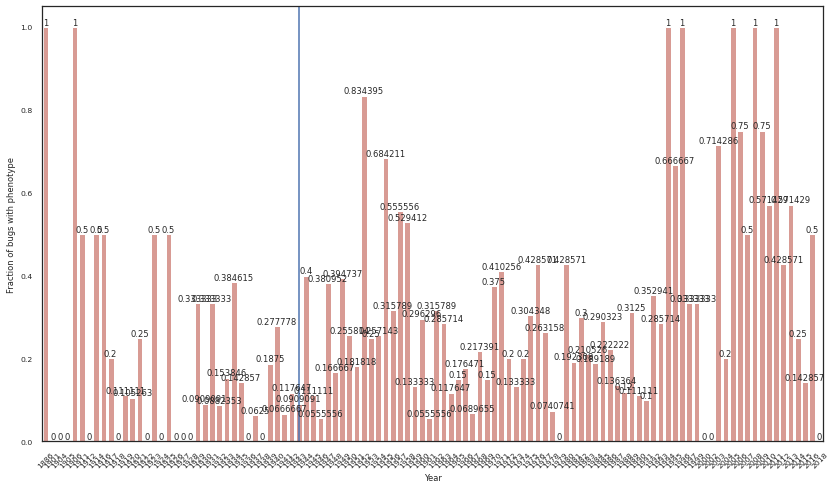

     Year  num_pos  all Anthropogenicity
0    1886        1    1        Pre-Human
1    1901        2    5        Pre-Human
2    1904        2    5        Pre-Human
3    1905        2    5        Pre-Human
4    1906        3    7        Pre-Human
..    ...      ...  ...              ...
102  2012       29   63       Post-Human
103  2013       28   62       Post-Human
104  2014       22   56       Post-Human
105  2015       19   52       Post-Human
106  2016       15   45       Post-Human

[107 rows x 4 columns]


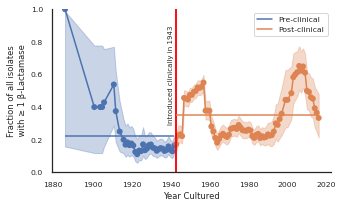

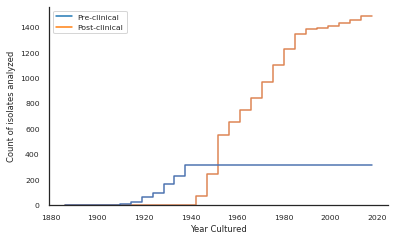

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


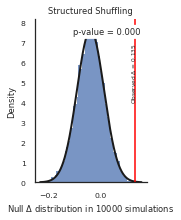

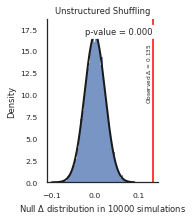

P-value (unstructured) = 0.0000


In [8]:
plot_abresist_frac_error(
    df=df,
    ex="beta-lactamase",
    year=1943,
    sims=10000,
    # sims=5,
    # sims=2000,
    verbose=False,
    col="AMR Gene Family",
    yaxis="Fraction of all isolates\n",
    value="≥ 1 β-Lactamase",
    savefig=True,
    smooth=5,
    figname="./figs/fig3/beta-lactamase/all-betalactamase",
)

## ESKAPE pathogens

In [9]:
eskape_pathogens = df.loc[
    df["Strain"].str.contains(
        "Enterococcus faecium|Salmonella enterica|Klebsiella pneumoniae|Acinetobacter baumannii|Pseudomonas aeruginosa|Enterobacter"
    )
].copy()
eskape_pathogens["CleanSpecies"] = eskape_pathogens["Strain"]
eskape_pathogens.loc[
    eskape_pathogens["Strain"].str.contains("Enterococcous faecium"), ["CleanSpecies"]
] = "Enterococcus faecium"
eskape_pathogens.loc[
    eskape_pathogens["Strain"].str.contains("Salmonella enterica"), ["CleanSpecies"]
] = "Salmonella enterica"
eskape_pathogens.loc[
    eskape_pathogens["Strain"].str.contains("Klebsiella pneumoniae"), ["CleanSpecies"]
] = "Klebsiella pneumoniae"
eskape_pathogens.loc[
    eskape_pathogens["Strain"].str.contains("Acinetobacter baumannii"), ["CleanSpecies"]
] = "Acinetobacter baumannii"
eskape_pathogens.loc[
    eskape_pathogens["Strain"].str.contains("Pseudomonas aeruginosa"), ["CleanSpecies"]
] = "Pseudomonas aeruginosa"
eskape_pathogens.loc[
    eskape_pathogens["Strain"].str.contains("Enterobacter"), ["CleanSpecies"]
] = "Enterobacter sp."
eskape_pathogens.drop_duplicates("Accession_Number").sort_values("Year_Cultured")
family_name = eskape_pathogens["CleanSpecies"].str.split(" ", expand=True)[0].str[0]
species_name = eskape_pathogens["CleanSpecies"].str.split(" ", expand=True)[1]
eskape_pathogens["Species"] = family_name + ". " + species_name
eskape_pathogens.loc[
    eskape_pathogens["Species"].str.match("E. sp."), ["Species"]
] = "Enterobacter sp."

    year  num_pos  all      frac Anthropogenicity
0   1911        1    2  0.500000        Pre-Human
1   1917        0    2  0.000000        Pre-Human
2   1918        0    1  0.000000        Pre-Human
3   1920        0    5  0.000000        Pre-Human
4   1925        1    1  1.000000        Pre-Human
..   ...      ...  ...       ...              ...
61  2008        5    5  1.000000       Post-Human
62  2010        2    3  0.666667       Post-Human
63  2011        3    3  1.000000       Post-Human
64  2012        2    2  1.000000       Post-Human
65  2013        1    1  1.000000       Post-Human

[66 rows x 5 columns]


/tmp/ipykernel_18775/2187956965.py:43: FutureWarning:

Passing method to Int64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.



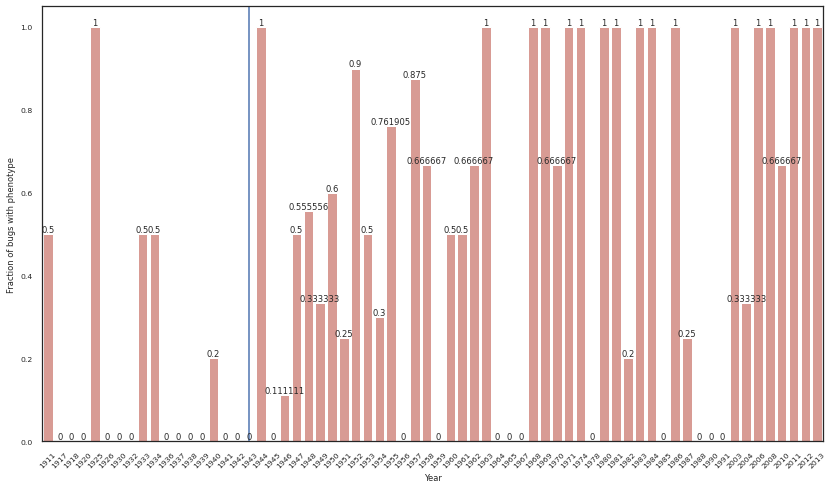

    Year  num_pos  all Anthropogenicity
0   1911        1    2        Pre-Human
1   1917        0    8        Pre-Human
2   1918        0    8        Pre-Human
3   1920        1    9        Pre-Human
4   1925        1   10        Pre-Human
..   ...      ...  ...              ...
60  2006       14   17       Post-Human
61  2008       17   20       Post-Human
62  2010       14   15       Post-Human
63  2011       14   15       Post-Human
64  2012       13   14       Post-Human

[65 rows x 4 columns]


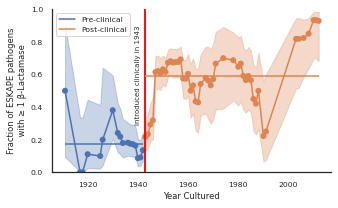

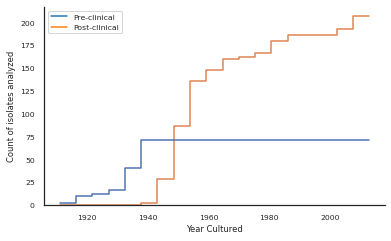

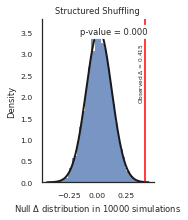

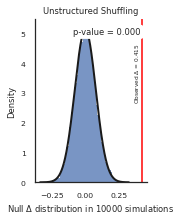

P-value (unstructured) = 0.0000


In [10]:
plot_abresist_frac_error(
    df=eskape_pathogens,
    ex="beta-lactamase",
    year=1943,
    sims=10000,
    yaxis="Fraction of ESKAPE pathogens\n",
    value="≥ 1 β-Lactamase",
    verbose=False,
    col="AMR Gene Family",
    savefig=True,
    smooth=5,
    figname="./figs/fig3/beta-lactamase/eskape-betalactamase",
)

## E. coli

In [ ]:
ecolidf = df.loc[
    (df["Strain"].str.contains("Escherichia coli"))
    & (~df["AMR Gene Family"].str.contains("EC beta-lactamase"))
]
# ecolidf
ecolidf.loc[
    ecolidf["AMR Gene Family"].str.contains("beta-lactamase", na=False, regex=True)
][["Best_Hit_ARO", "AMR Gene Family"]].value_counts()

In [ ]:
plot_abresist_frac_error(
    df=ecolidf,
    ex="beta-lactamase",
    year=1943,
    sims=5000,
    # sims=5,
    # sims=5,
    verbose=False,
    col="AMR Gene Family",
    value="≥ 1 β-Lactamase",
    savefig=True,
    smooth=5,
    figname="./figs/fig4/beta-lactamase/ecoli-betalactamase",
)

## K. pneumoniae

In [ ]:
klebdf = df.loc[
    df["Strain"].str.contains("Klebsiella pneumoniae")
    # & ~df["AMR Gene Family"].str.contains("SHV beta-lactamase")
]

In [ ]:
klebdf.loc[
    klebdf["AMR Gene Family"].str.contains("beta-lactamase", na=False, regex=True)
][["Best_Hit_ARO", "AMR Gene Family"]].value_counts()

In [ ]:
plot_abresist_frac_error(
    df=klebdf,
    ex="beta-lactamase",
    year=1943,
    sims=5000,
    # sims=5,
    # sims=0,
    verbose=False,
    col="AMR Gene Family",
    value="≥ 1 β-Lactamase",
    savefig=True,
    smooth=5,
    figname="./figs/fig4/beta-lactamase/kleb-betalactamase",
)

## S. enterica

In [ ]:
salmdf = df.loc[df["Strain"].str.contains("Salmonella enterica")]

In [ ]:
salmdf.loc[
    salmdf["AMR Gene Family"].str.contains("beta-lactamase", na=False, regex=True)
][["Best_Hit_ARO", "AMR Gene Family"]].value_counts()

In [ ]:
plot_abresist_frac_error(
    df=salmdf,
    ex="beta-lactamase",
    year=1943,
    sims=5000,
    # sims=5,
    # sims=0,
    verbose=False,
    col="AMR Gene Family",
    value="≥ 1 β-Lactamase",
    savefig=False,
    smooth=5,
    figname="./figs/fig4/beta-lactamase/salm-betalactamase",
)

## S. aureus

In [ ]:
staphdf = df.loc[df["Strain"].str.contains("Staphylococcus aureus")]
staphdf.columns

In [ ]:
staphdf.loc[
    staphdf["AMR Gene Family"].str.contains("beta-lactamase", na=False, regex=True)
][["Best_Hit_ARO", "AMR Gene Family"]].value_counts()

In [ ]:
plot_abresist_frac_error(
    df=staphdf,
    ex="beta-lactamase",
    year=1943,
    sims=5000,
    # sims=5,
    # sims=0,
    verbose=False,
    col="AMR Gene Family",
    value="≥ 1 β-Lactamase",
    savefig=True,
    smooth=5,
    figname="./figs/fig4/beta-lactamase/staph-betalactamase",
)

## S. pyogenes

In [ ]:
pyogdf = df.loc[df["Strain"].str.contains("Streptococcus pyogenes")]

In [ ]:
pyogdf.loc[
    pyogdf["AMR Gene Family"].str.contains("beta-lactamase", na=False, regex=True)
][["Best_Hit_ARO", "AMR Gene Family"]].value_counts()

In [ ]:
plot_abresist_frac_error(
    df=pyogdf,
    ex="beta-lactamase",
    year=1943,
    sims=5000,
    # sims=5,
    # sims=0,
    verbose=False,
    col="AMR Gene Family",
    value="≥ 1 β-Lactamase",
    savefig=True,
    smooth=5,
    figname="./figs/fig4/beta-lactamase/pyog-betalactamase",
)

# Use AMRFinder

In [12]:
amrfinder_df = pd.read_csv(
    "../../data/5_amrfinderplus/merged_amrfinderout",
    sep="\t",
    names=[
        "Accession_Number",
        "Protein identifier",
        "Contig id",
        "Start",
        "Stop",
        "Strand",
        "Gene symbol",
        "Sequence name",
        "Scope",
        "Element type",
        "Element subtype",
        "Class",
        "Subclass",
        "Method",
        "Target length",
        "Reference sequence length",
        "Coverage of reference sequence",
        "% Identity to reference sequence",
        "Alignment length",
        "Accession of closest sequence",
        "Name of closest sequence",
        "HMM id",
        "HMM description",
    ],
)
amrfinder_df = pd.merge(
    amrfinder_df,
    df.drop_duplicates("Accession_Number")[
        ["Accession_Number", "Species", "Year_Cultured"]
    ],
    on="Accession_Number",
    how="left",
)
failed_qc = pd.read_csv("/n/data1/hms/dbmi/baym/arya/projects/project_microtrawler/data/6_checkm2/failed_filter.tsv", sep="\t")
amrfinder_df = amrfinder_df[~amrfinder_df['Accession_Number'].isin(failed_qc['NCTC_Isolate'])]

amrfinder_df["Species"].value_counts()

Escherichia coli                    623
Staphylococcus aureus               554
Klebsiella pneumoniae               368
Pseudomonas aeruginosa              319
Salmonella enterica                 106
                                   ... 
Moraxella (branhamella) cuniculi      1
Chryseobacterium balustinum           1
Moraxella bovis                       1
Streptococcus thermophilus            1
Moraxella equi                        1
Name: Species, Length: 586, dtype: int64

In [ ]:
# amrfinder_df[["Class", "Subclass"]].value_counts()

In [ ]:
amrfinder_df.loc[
    amrfinder_df["Subclass"].str.contains("KANAMYCIN", na=False)
    & (amrfinder_df["Species"].str.contains("Acinetobacter"))
].sort_values("Year_Cultured")

In [ ]:
amrfinder_df["Species"].value_counts()

In [ ]:
def measure_obs_distance(
    dataframe, value, anthro_year, column, sums=False, verbose=False
):
    num_yearcultured_allstrains_dict = (
        dataframe.drop_duplicates(subset=["Accession_Number"])["Year_Cultured"]
        .value_counts()
        .to_dict()
    )
    num_yearcultured_valposstrains_dict = (
        dataframe.loc[dataframe[column].str.contains(value, na=False, regex=True)]
        .drop_duplicates(subset=["Accession_Number"])["Year_Cultured"]
        .value_counts()
        .to_dict()
    )
    fractional_dictionary = {}
    for years in num_yearcultured_allstrains_dict:
        if num_yearcultured_allstrains_dict[years] == 0:
            continue
        if years in num_yearcultured_valposstrains_dict:
            val = [
                num_yearcultured_valposstrains_dict[years],
                num_yearcultured_allstrains_dict[years],
            ]
            # fraction = (
            #     num_yearcultured_valposstrains_dict[years]
            #     / num_yearcultured_allstrains_dict[years]
            # )
        else:
            val = [0, num_yearcultured_allstrains_dict[years]]
        fractional_dictionary[years] = val

    yeardf = (
        pd.DataFrame.from_dict(
            fractional_dictionary, orient="index", columns=["num_pos", "all"]
        )
        .reset_index()
        .rename(columns={"index": "year"})
        .sort_values(by="year")
        .reset_index(drop=True)
    )
    yeardf["frac"] = yeardf["num_pos"] / yeardf["all"]
    if verbose:
        print(yeardf)
    anthro = {True: "Pre-Human", False: "Post-Human"}
    # line = pd.Index(yeardf["year"]).get_loc(anthro_year)
    # yeardf["row"] = np.arange(yeardf.shape[0])
    # yeardf["Anthropogenicity"] = "Pre-Human"
    # yeardf.loc[yeardf["row"] > line, "Anthropogenicity"] = "Post-Human"
    yeardf["Anthropogenicity"] = "Pre-Human"
    yeardf.loc[yeardf["year"] > anthro_year, "Anthropogenicity"] = "Post-Human"

    preanthro_mean = yeardf.loc[yeardf["Anthropogenicity"] == "Pre-Human"][
        "frac"
    ].mean()
    postanthro_mean = yeardf.loc[yeardf["Anthropogenicity"] == "Post-Human"][
        "frac"
    ].mean()
    metric = postanthro_mean - preanthro_mean
    # print("Pre-Human mean fraction = %s" % (preanthro_mean))
    # print("Post-Human mean fraction = %s" % (postanthro_mean))
    # print("metric = %s" % (metric))
    return yeardf, preanthro_mean, postanthro_mean


# shuffle year_cultured information while retaining existing structure.
#  i.e. all 1940 strains get remapped to 2019, all 2019 strains get remapped to 1982, etc.
def shuffleyears_structured(
    dataframe, value, anthro_year, column, verbose=False, simulations=500
):
    null_distances = []
    sortedyears = dataframe["Year_Cultured"].unique()
    for sim in range(simulations):
        copy_df = dataframe.copy()
        shuffledyears = dataframe["Year_Cultured"].sample(frac=1).unique()
        remapping = dict(zip(sortedyears, shuffledyears))
        copy_df["Year_Cultured"] = dataframe["Year_Cultured"].map(remapping)
        yeardf, pre, post = measure_obs_distance(
            copy_df, value, anthro_year, column, verbose
        )
        null_distances.append(post - pre)
    return null_distances


# shuffle year_cultured information while NOT retaining existing structure.
#  i.e. some 1940 strains can get remapped to 2019, some can get remapped to 1930, etc.
def shuffleyears_unstructured(
    dataframe, value, anthro_year, column, verbose=False, simulations=500
):
    null_distances = []
    sortedyears = dataframe["Year_Cultured"].unique()
    uq_strains = (
        dataframe.groupby(["Accession_Number", "Year_Cultured"], sort=False)
        .size()
        .reset_index()
    )
    uq_strains.set_index("Accession_Number", inplace=True)
    uq_strains.drop(columns=[0, "Year_Cultured"], inplace=True)
    for sim in range(simulations):
        uq_strains["RandomChoice"] = np.random.choice(sortedyears, uq_strains.shape[0])
        copy_df = dataframe.copy()
        remapping = uq_strains.to_dict()["RandomChoice"]
        copy_df["Year_Cultured"] = dataframe["Accession_Number"].map(remapping)
        yeardf, pre, post = measure_obs_distance(
            copy_df, value, anthro_year, column, verbose
        )
        null_distances.append(post - pre)
    return null_distances

In [ ]:
import scipy.stats as stats
from scipy.stats import binom


def calculate_frequency_bounds(row, confidence=0.95):
    successes = row["num_pos"]
    attempts = row["all"]
    freq = row["num_pos"] / row["all"]
    alpha = successes + 1
    beta = attempts - successes + 1
    lower_b, upper_b = stats.beta.interval(confidence, alpha, beta)
    # return (freq - lower_b, upper_b - freq)
    return (lower_b, upper_b)


def plot_abresist_frac_error(
    df,
    ex,
    year,
    verbose=True,
    sims=100,
    figname="doodoo",
    savefig=False,
    smooth=5,
    col="Drug Class",
    value="phenotype",
):

    sns.set_theme(font="Arial", style="white", font_scale=0.7)

    frac_df, pre, post = measure_obs_distance(df, ex, year, col, verbose)
    dist = post - pre

    print(frac_df)

    # histogram of fraction of strains w/ RGI hits for drug class
    plt.figure(figsize=(14, 8))
    chart = sns.barplot(
        data=frac_df, x="year", y="frac", color="salmon", saturation=0.5
    )
    chart.bar_label(chart.containers[0])

    plt.axvline(pd.Index(frac_df["year"]).get_loc(year, method="nearest"))
    plt.ylabel("Fraction of bugs with phenotype")
    plt.xlabel("Year")
    plt.xticks(rotation=45)

    plt.show()

    d = {"Year": [], "num_pos": [], "all": [], "Anthropogenicity": []}
    # xdf is the fractional df denoting the fraction of bugs w/ resistance
    for years in range(frac_df["year"].min(), frac_df["year"].max()):
        upb = smooth + years
        downb = years - smooth
        g = frac_df.loc[(frac_df["year"] <= upb) & (downb <= frac_df["year"])]
        if years not in frac_df["year"].values:
            continue
        d["Year"].append(years)
        if years >= year:
            d["Anthropogenicity"].append("Post-Human")
        else:
            d["Anthropogenicity"].append("Pre-Human")
        d["num_pos"].append(g["num_pos"].sum())
        d["all"].append(g["all"].sum())
        # print(d)
        # d["frac"].append(d['num_pos'][0]/d['all'][0])
    xdf = pd.DataFrame(data=d)
    print(xdf)
    xdf["frac"] = xdf["num_pos"] / xdf["all"]
    # xdf["error"] = np.sqrt(xdf["frac"] * (1 - xdf["frac"]) / xdf["all"])
    xdf[["lower-error", "upper-error"]] = xdf.apply(
        calculate_frequency_bounds, axis=1, result_type="expand"
    )
    # xdf["se"] = 1.96 * xdf["error"]
    # xdf["ci_high"], xdf["ci_high"] = binom.interval(0.95, xdf["all"], xdf["frac"])
    # print(xdf)

    # make subplots for the figure
    fig1, ax1 = plt.subplots(figsize=(14, 8))

    ax1.set(xlabel="Year Cultured")

    lp = sns.lineplot(
        data=xdf,
        x="Year",
        y="frac",
        markers=True,
        hue="Anthropogenicity",
        palette=[sns.color_palette("deep")[0], sns.color_palette("deep")[1]],
        # legend=False,
        ax=ax1,
    )
    lp.set(ylim=(0, 1))

    # Get the current legend
    legend = ax1.legend()

    # Change the legend title
    legend.set_title("")

    # Change legend labels
    new_labels = ["Pre-clinical", "Post-clinical"]
    for t, l in zip(
        legend.texts[0:], new_labels
    ):  # Skip the first text which is the title
        t.set_text(l)

    dp = sns.scatterplot(
        data=xdf,
        x="Year",
        y="frac",
        hue="Anthropogenicity",
        palette=[sns.color_palette("deep")[0], sns.color_palette("deep")[1]],
        legend=False,
        ax=ax1,
        edgecolor="none",
    )
    plt.fill_between(
        xdf.loc[xdf["Year"] < year]["Year"],
        xdf.loc[xdf["Year"] < year]["lower-error"],
        xdf.loc[xdf["Year"] < year]["upper-error"],
        alpha=0.3,
        edgecolor=sns.color_palette("deep")[0],
        facecolor=sns.color_palette("deep")[0],
    )
    plt.fill_between(
        xdf.loc[xdf["Year"] >= year]["Year"],
        xdf.loc[xdf["Year"] >= year]["lower-error"],
        xdf.loc[xdf["Year"] >= year]["upper-error"],
        alpha=0.3,
        edgecolor=sns.color_palette("deep")[1],
        facecolor=sns.color_palette("deep")[1],
    )
    sns.despine()

    # ax1.errorbar(
    #     xdf.loc[xdf["Year"] < year]["Year"],
    #     xdf.loc[xdf["Year"] < year]["frac"],
    #     yerr=[
    #         xdf.loc[xdf["Year"] < year]["lower-error"],
    #         xdf.loc[xdf["Year"] < year]["upper-error"],
    #     ],
    #     fmt="none",
    #     capsize=3,
    #     capthick=1,
    #     color=sns.color_palette("deep")[0],
    #     errorevery=2,
    # )
    # ax1.errorbar(
    #     xdf.loc[xdf["Year"] >= year]["Year"],
    #     xdf.loc[xdf["Year"] >= year]["frac"],
    #     yerr=[
    #         xdf.loc[xdf["Year"] >= year]["lower-error"],
    #         xdf.loc[xdf["Year"] >= year]["upper-error"],
    #     ],
    #     fmt="none",
    #     capsize=3,
    #     capthick=1,
    #     color=sns.color_palette("deep")[1],
    #     errorevery=2,
    # )
    plt.axvline(year, color="red")
    # dp = sns.pointplot(
    #     data=xdf,
    #     x="Year",
    #     y="frac",
    #     hue="Anthropogenicity",
    #     palette=[sns.color_palette("deep")[0], sns.color_palette("deep")[1]],
    #     legend=False,
    #     ax=ax1,
    # )
    ax1.set(ylabel="Fraction of isolates with {}".format(value))
    plt.axvline(year, color="red")  # , label='{} introduced'.format(year))
    trans = ax1.get_xaxis_transform()
    # x = 10
    plt.text(
        year - 4,
        0.3,
        "Introduced clinically in {}".format(year),
        rotation=90,
        transform=trans,
        fontsize="small",
    )
    preab_df = xdf.loc[xdf["Anthropogenicity"] == "Pre-Human"]
    lp.hlines(
        y=preab_df["frac"].mean(),
        xmin=preab_df["Year"].min(),
        xmax=preab_df["Year"].max(),
        color=sns.color_palette("deep")[0],
    )

    postab_df = xdf.loc[xdf["Anthropogenicity"] == "Post-Human"]
    lp.hlines(
        y=postab_df["frac"].mean(),
        xmin=postab_df["Year"].min(),
        xmax=postab_df["Year"].max(),
        color=sns.color_palette("deep")[1],
    )
    if savefig:
        plt.gcf().set_size_inches(5.0, 3)
        plt.savefig(
            "{}-fractionofresist.svg".format(figname),
            bbox_inches="tight",
            dpi=300,
        )

    fig2, ax2 = plt.subplots(figsize=(14, 8))
    ax2.set(ylabel="Count of isolates analyzed", xlabel="Year Cultured")

    # ax2 = ax1.twinx()

    # create another copy of the dataframe
    drop_dups = df.drop_duplicates(subset=["Accession_Number"]).copy()
    drop_dups["Anthropogenicity"] = "Post-Human"
    # print(drop_dups)

    drop_dups.loc[drop_dups["Year_Cultured"] < year, ["Anthropogenicity"]] = "Pre-Human"
    histogram = sns.histplot(
        data=drop_dups,
        x="Year_Cultured",
        hue="Anthropogenicity",
        palette=[sns.color_palette("deep")[0], sns.color_palette("deep")[1]],
        ax=ax2,
        # multiple="stack",
        # linewidth=0.3,
        cumulative=True,
        fill=False,
        element="step",
    )
    # dp.axvline(year, color="red")#, label='{} introduced'.format(year))
    # plt.legend()
    # plt.text(4, 1, f'{year} introduce', ha='left', va='center')
    sns.despine()
    if savefig:
        plt.gcf().set_size_inches(5.0, 3)
        plt.savefig(
            "{}-histogram.svg".format(figname),
            bbox_inches="tight",
            dpi=300,
        )
    plt.show()

    #     fig, ax1 = plt.subplots()

    #     ax2 = ax1.twinx()

    #     sns.barplot(x="Announced Year", y="Amount Awarded", data=df, ax=ax2, alpha=.5)
    #     sns.scatterplot(x=np.arange(0,len(df)), y="Number of Awarded", data=df, ax=ax1)

    #     fig.tight_layout()  # otherwise the right y-label is slightly clipped

    #     plt.title('2016 to 2019 Announcements')

    if sims == 0:
        return

    preab_mean = frac_df.loc[frac_df["Anthropogenicity"] == "Pre-Human"]["frac"].mean()
    postab_mean = frac_df.loc[frac_df["Anthropogenicity"] == "Post-Human"][
        "frac"
    ].mean()

    nulldist = shuffleyears_structured(df, ex, year, col, verbose, simulations=sims)
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.histplot(
        nulldist, stat="density", color=sns.color_palette("deep")[0], linewidth=0
    )
    xmin, xmax = plt.xlim()
    mu_struct, std_struct = norm.fit(nulldist)
    x = np.linspace(xmin, xmax, sims)
    y_pdf = norm.pdf(x, mu_struct, std_struct)
    plt.plot(x, y_pdf, "k", linewidth=2)
    plt.axvline(dist, color="red")
    trans = ax.get_xaxis_transform()
    # x = 10
    plt.text(
        dist * 0.85,
        0.5,
        "Observed $\Delta$ = {:.3f}".format(dist),
        rotation=90,
        transform=trans,
        fontsize="x-small",
    )
    # plt.legend()
    plt.title("Structured Shuffling")
    plt.xlabel("Null $\Delta$ distribution in {} simulations".format(sims))
    if savefig:
        plt.gcf().set_size_inches(2, 3)
        plt.savefig(
            "{}-structuredshuffling.svg".format(figname), bbox_inches="tight", dpi=300
        )
    plt.show()
    pval = norm.cdf(dist, mu_struct, std_struct)
    if pval > 0.5:
        pval = 1 - pval
    print("P-value (structured) = {:.4f}".format(pval))

    nulldist = shuffleyears_unstructured(df, ex, year, col, verbose, simulations=sims)
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.histplot(
        nulldist, stat="density", color=sns.color_palette("deep")[0], edgecolor="none"
    )
    xmin, xmax = plt.xlim()
    mu_unstruct, std_unstruct = norm.fit(nulldist)
    x = np.linspace(xmin, xmax, sims)
    y_pdf = norm.pdf(x, mu_unstruct, std_unstruct)
    plt.plot(x, y_pdf, "k", linewidth=2)
    plt.axvline(dist, color="red")
    trans = ax.get_xaxis_transform()
    # x = 10
    plt.text(
        dist * 0.85,
        0.5,
        "Observed $\Delta$ = {:.3f}".format(dist),
        rotation=90,
        transform=trans,
        fontsize="x-small",
    )
    # plt.legend()
    plt.title("Unstructured Shuffling")
    plt.xlabel("Null $\Delta$ distribution in {} simulations".format(sims))
    if savefig:
        plt.gcf().set_size_inches(2, 3)
        plt.savefig(
            "{}-unstructuredshuffling.svg".format(figname), bbox_inches="tight", dpi=300
        )
    plt.show()
    pval = norm.cdf(dist, mu_unstruct, std_unstruct)
    if pval > 0.5:
        pval = 1 - pval
    print("P-value (unstructured) = {:.4f}".format(pval))

In [ ]:
plot_abresist_frac_error(
    df=amrfinder_df,
    ex="lactamase",
    year=1943,
    sims=10000,
    # sims=5,
    # sims=0,
    verbose=False,
    col="Sequence name",
    value="≥ 1 β-Lactamase",
    savefig=True,
    smooth=5,
    figname="./figs/fig4/all-betalactamase-NCBI",
)

In [ ]:
plot_abresist_frac_error(
    df=amrfinder_df.loc[
        amrfinder_df["Species"].str.contains(
            "Escherichia coli|Staphylococcus aureus|Enterococcous faecium|Salmonella enterica|Klebsiella pneumoniae|Acinetobacter baumannii|Pseudomonas aeruginosa|Enterobacter|Streptococcus pneumoniae|Streptococcus pyogenes"
        )
    ],
    ex="lactamase",
    year=1943,
    sims=10000,
    # sims=5,
    # sims=0,
    verbose=False,
    col="Sequence name",
    value="≥ 1 β-Lactamase",
    savefig=True,
    smooth=5,
    figname="./figs/fig4/organismblacklisted-betalactamase-NCBI",
)

# Meta-analysis

In [ ]:
drugyear_usage = {
    "fluoroquinolone antibiotic": 1962,
    "penam": 1943,
    "cephalosporin": 1964,
    "tetracycline antibiotic": 1948,
    "phenicol antibiotic": 1949,
    "macrolide antibiotic": 1952,
    "rifamycin antibiotic": 1963,
    "aminoglycoside antibiotic": 1946,
    # "peptide antibiotic": 1941,  # not sure about this one
    # "glycylcycline": 1948,  # using year tetracyclines were introduced clinically
    # "triclosan": 1968,  # using wiki page
    # "cephamycin": 1964,  # using cephalosporin year
    "carbapenem": 1985,
    # "aminocoumarin antibiotic": 1965,  # best guess from wiki article
    # "penem": 1985,  # using year carbapenems were introduced
    "monobactam": 1986,
    # "disinfecting agents and intercalating dyes": 1930,  # no clue
    # "acridine dye": 1970,  # no clue?
    # "diaminopyrimidine antibiotic": 1962,
    # "elfamycin antibiotic": 1978,  # no clue
    # "fosfomycin": 1971,
    # "nucleoside antibiotic": 2014,  # no clue, but looks newish
    "lincosamide antibiotic": 1963,
    # "nitroimidazole antibiotic": 1960,
    # "Null": 1920,
    # "benzalkonium chloride": 1950,  # no clude
    # "rhodamine": 1950,  # no clude
    "sulfonamide antibiotic": 1936,
    "nitrofuran antibiotic": 1953,
    # "streptogramin antibiotic": 1965,
    # "oxazolidinone antibiotic": 2000,
    "glycopeptide antibiotic": 1958,
    # "fusidic acid": 1962,
    # "pleuromutilin antibiotic": 2007,
    # "bicyclomycin": 1972,  # from wiki
    # "antibacterial free fatty acids": 2000,  # noclude
    # "para-aminosalicylic acid": 1943,
    # "isoniazid": 1952,
    # "polyamine antibiotic": 2005,  # no idea
}

In [ ]:
confident_drugyears = [
    "fluoroquinolone antibiotic",
    "penam",
    "cephalosporin",
    "tetracycline antibiotic",
    "phenicol antibiotic",
    "macrolide antibiotic",
    "rifamycin antibiotic",
    "aminoglycoside antibiotic",
    "carbapenem",
    "monobactam",
    "diaminopyrimidine antibiotic",
    "fosfomycin",
    "lincosamide antibiotic",
    "nitroimidazole antibiotic",
    "sulfonamide antibiotic",
    "nitrofuran antibiotic",
    "streptogramin antibiotic",
    "oxazolidinone antibiotic",
    "glycopeptide antibiotic",
    "fusidic acid",
    "pleuromutilin antibiotic",
    "para-aminosalicylic acid",
    "isoniazid",
]

In [ ]:
drug_count = {}
for x in list(df["Drug Class"]):
    classes = x.split("; ")
    for c in classes:
        if c in drug_count:
            drug_count[c] += 1
        else:
            drug_count[c] = 1
allbugs_allresist = pd.read_csv(
    "./10000sims-ALL-pvalues",
    names=["Drug Class", "Delta", "Struct_Pval", "Unstruct_Pval"],
    skiprows=[0],
)
allbugs_allresist["NumHits"] = allbugs_allresist["Drug Class"].map(drug_count)
allbugs_allresist = allbugs_allresist.loc[
    allbugs_allresist["Drug Class"].str.match("|".join(confident_drugyears))
].sort_values("Struct_Pval")
allbugs_allresist

In [ ]:
plot_abresist_frac(
    df=df,
    ex="aminoglycoside antibiotic",
    year=drugyear_usage["aminoglycoside antibiotic"],
    sims=0,
    verbose=True,
    col="Drug Class",
    value="",
    savefig=False,
)

In [ ]:
drug_count = {}
for x in list(
    df.loc[~df["Resistance Mechanism"].str.match("antibiotic efflux")]["Drug Class"]
):
    classes = x.split("; ")
    for c in classes:
        if c in drug_count:
            drug_count[c] += 1
        else:
            drug_count[c] = 1
allbugs_noeff = pd.read_csv(
    "./10000sims-ALL-noefflux-pvalues",
    names=["Drug Class", "Delta", "Struct_Pval", "Unstruct_Pval"],
    skiprows=[0],
)
allbugs_noeff["NumHits"] = allbugs_noeff["Drug Class"].map(drug_count)
allbugs_noeff = allbugs_noeff.loc[
    allbugs_noeff["Drug Class"].str.match("|".join(confident_drugyears))
].sort_values("Struct_Pval")
allbugs_noeff

In [ ]:
eskape_bugs = [
    "Enterococcus faecium",
    "Staphylococcus aureus",
    "Klebsiella pneumoniae",
    "Acinetobacter baumannii",
    "Pseudomonas aeruginosa",
    "Enterobacter",
]
eskapedf = df.loc[df["Strain"].str.contains("|".join(eskape_bugs))].copy()
eskapedf["SpeciesName"] = "NONE"
eskapedf.loc[
    eskapedf["Strain"].str.contains("Enterococcus faecium"), "SpeciesName"
] = "Enterococcus faecium"
eskapedf.loc[
    eskapedf["Strain"].str.contains("Staphylococcus aureus"), "SpeciesName"
] = "Staphylococcus aureus"
eskapedf.loc[
    eskapedf["Strain"].str.contains("Klebsiella pneumoniae"), "SpeciesName"
] = "Klebsiella pneumoniae"
eskapedf.loc[
    eskapedf["Strain"].str.contains("Acinetobacter baumannii"), "SpeciesName"
] = "Acinetobacter baumannii"
eskapedf.loc[
    eskapedf["Strain"].str.contains("Pseudomonas aeruginosa"), "SpeciesName"
] = "Pseudomonas aeruginosa"
eskapedf.loc[
    eskapedf["Strain"].str.contains("Enterobacter"), "SpeciesName"
] = "Enterobacter"

eskape_integron = rgiintegron.loc[
    rgiintegron["Strain"].str.contains("|".join(eskape_bugs))
].copy()
eskapedf["Integron"] = "False"
m = eskapedf["ORF_ID"].isin(eskape_integron["ORF_ID"])
eskapedf.loc[m, "Integron"] = "True"
# eskapedf['Integron'].value_counts()

eskapedf["Plasmid"] = "Null"
eskapedf.loc[
    (eskapedf["SpeciesName"] == "Klebsiella pneumoniae")
    | (eskapedf["SpeciesName"] == "Enterococcus faecium")
    | (eskapedf["SpeciesName"] == "Acinetobacter baumannii"),
    "Plasmid",
] = "False"
eskapedf.loc[
    eskapedf["ORF_ID"].isin(
        pd.concat([faeciumplasmids_df, baumanniiplasmids_df, klebplasmids_df])["ORF_ID"]
    ),
    "Plasmid",
] = "True"
df.drop_duplicates("Accession_Number")["Strain"].value_counts()

In [ ]:
drug_count = {}
for x in list(eskapedf["Drug Class"]):
    classes = x.split("; ")
    for c in classes:
        if c in drug_count:
            drug_count[c] += 1
        else:
            drug_count[c] = 1
# print(drug_count)
eskape_allresist = pd.read_csv(
    "./10000sims-ESKAPE-pvalues",
    names=["Drug Class", "Delta", "Struct_Pval", "Unstruct_Pval"],
    skiprows=[0],
)
eskape_allresist["NumHits"] = eskape_allresist["Drug Class"].map(drug_count)
eskape_allresist = eskape_allresist.loc[
    eskape_allresist["Drug Class"].str.match("|".join(confident_drugyears))
].sort_values("Struct_Pval")
eskape_allresist

In [ ]:
drug_count = {}
for x in list(
    eskapedf.loc[~eskapedf["Resistance Mechanism"].str.match("antibiotic efflux")][
        "Drug Class"
    ]
):
    classes = x.split("; ")
    for c in classes:
        if c in drug_count:
            drug_count[c] += 1
        else:
            drug_count[c] = 1
# print(drug_count)
eskape_noeff = pd.read_csv(
    "./10000sims-ESKAPE-noefflux-pvalues",
    names=["Drug Class", "Delta", "Struct_Pval", "Unstruct_Pval"],
    skiprows=[0],
)
eskape_noeff["NumHits"] = eskape_noeff["Drug Class"].map(drug_count)
eskape_noeff = eskape_noeff.loc[
    eskape_noeff["Drug Class"].str.match("|".join(confident_drugyears))
].sort_values("Struct_Pval")
eskape_noeff

In [ ]:
allbugs_allresist["Dataset"] = "Full Data"
allbugs_noeff["Dataset"] = "Full Data"
eskape_noeff["Dataset"] = "ESKAPE"
eskape_allresist["Dataset"] = "ESKAPE"
allbugs_allresist["Mechanism"] = "All"
allbugs_noeff["Mechanism"] = "No Efflux"
eskape_noeff["Mechanism"] = "No Efflux"
eskape_allresist["Mechanism"] = "All"
tenthousandsims_values = pd.concat(
    [
        allbugs_noeff.loc[allbugs_noeff["NumHits"] > 10],
        allbugs_allresist.loc[allbugs_allresist["NumHits"] > 10],
        eskape_noeff.loc[eskape_noeff["NumHits"] > 10],
        eskape_allresist.loc[eskape_allresist["NumHits"] > 10],
    ]
)

In [ ]:
fig = px.scatter(
    tenthousandsims_values,
    x="Drug Class",
    y="Struct_Pval",
    symbol="Mechanism",
    # stripmode='overlay',
    color="Dataset",
    hover_data=["NumHits"],
    # log_y=True,
    labels={"Struct_Pval": "P-value"},
    title="Significance of human production of a given drug class on resistome",
)
fig.add_hline(y=0.1, annotation_text="P-value = 0.1")
# fig.write_image("drugclass_pvals.pdf")